In [16]:
!pip install lightgbm
!pip install shap
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler


In [17]:
#KAGGLE HAS BEEN USED THROUGH OUT FOR THE EASE OF ACCESS TO THIS PROJECT FOR EVERYONE 

import pandas as pd
import numpy as np

# Load datasets
dev_data = pd.read_csv('/kaggle/input/dev-data-to-be-shared/Dev_data_to_be_shared.csv')
test_data= pd.read_csv('/kaggle/input/validation-data/validation_data_to_be_shared.csv')

# Preview the datasets
print("Development Data:")
print(dev_data.head())
print("\nValidation Data:")
print(test_data.head())


Development Data:
   account_number  bad_flag  onus_attribute_1  transaction_attribute_1  \
0               1         0               NaN                      NaN   
1               2         0          221000.0                      0.0   
2               3         0           25000.0                      0.0   
3               4         0           86000.0                      0.0   
4               5         0          215000.0                      0.0   

   transaction_attribute_2  transaction_attribute_3  transaction_attribute_4  \
0                      NaN                      NaN                      NaN   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   transaction_attribute_5  transaction_attribute_6  tra

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score , log_loss
import lightgbm as lgb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Reset the index of the dataset
X = dev_data.drop(columns=['account_number', 'bad_flag']).reset_index(drop=True).values
y = dev_data['bad_flag'].reset_index(drop=True).values

# Retain the account numbers for validation data
val_account_numbers =test_data['account_number']
X_validation = test_data.drop(columns=['account_number'])
#Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_val_scaled = scaler.transform(X_validation)
# LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'min_child_samples': 50,
    'num_leaves': 31,
    'max_depth': 6,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'verbose': -1,
    
}

# K-Fold Cross-Validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_aucs = []
fold_log_losses = []

print("Starting K-Fold Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Processing Fold {fold + 1}...")
    
    # Split the data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
        lgb.early_stopping(stopping_rounds=50),   
        lgb.log_evaluation(period=50)
        ]
    )
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    
    # Calculate AUC
    fold_auc = roc_auc_score(y_val, y_pred)
    fold_aucs.append(fold_auc)
    
    # Calculate Log Loss
    fold_log_loss = log_loss(y_val, y_pred)
    fold_log_losses.append(fold_log_loss)

    print(f"Fold {fold + 1}: Validation AUC = {fold_auc:.4f}, Log Loss = {fold_log_loss:.4f}")
    import matplotlib.pyplot as plt

# Calculate Average AUC
avg_auc = np.mean(fold_aucs)
avg_log_loss = np.mean(fold_log_losses)
print(f"\nAverage Validation AUC across {n_splits} folds: {avg_auc:.4f}")
print(f"Average Validation Log Loss across {n_splits} folds: {avg_log_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Starting K-Fold Cross-Validation...
Processing Fold 1...
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.895973	valid's auc: 0.800709
[100]	train's auc: 0.931342	valid's auc: 0.809328
[150]	train's auc: 0.951642	valid's auc: 0.816701
[200]	train's auc: 0.964025	valid's auc: 0.817711
[250]	train's auc: 0.971942	valid's auc: 0.819717
[300]	train's auc: 0.978481	valid's auc: 0.820229
[350]	train's auc: 0.982537	valid's auc: 0.821799
Early stopping, best iteration is:
[330]	train's auc: 0.981227	valid's auc: 0.821828
Fold 1: Validation AUC = 0.8218, Log Loss = 0.0636
Processing Fold 2...
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.893099	valid's auc: 0.818858
[100]	train's auc: 0.92831	valid's auc: 0.822942
[150]	train's auc: 0.949143	valid's auc: 0.830108
[200]	train's auc: 0.962116	valid's auc: 0.83336
[250]	train's auc: 0.970429	valid's auc: 0.835035
[300]	train's auc: 0.977918	valid's auc: 0.835952
[350]	train's auc:

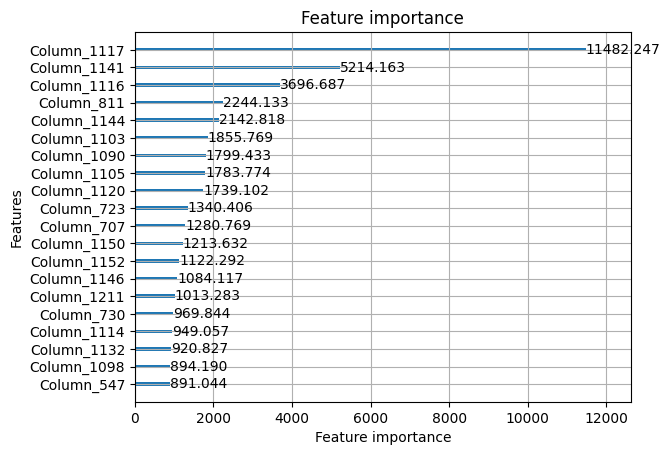

In [19]:
# Plot feature importance
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.show()


In [20]:
val_account_numbers =test_data['account_number']
X_validation = test_data.drop(columns=['account_number'])

In [21]:
# Make predictions for validation data
val_predictions = model.predict(X_validation)

# Restrict probabilities to 6 decimal places
val_predictions = np.round(val_predictions, 6)

#rounding off the predicted probabilities upto 6 decimals for the ease of understanding 



In [22]:
# Create a submission DataFrame
submission = pd.DataFrame({
    'account_number': val_account_numbers,  # Primary key
    'predicted_probability': val_predictions  # Rounded probabilities
})

# Save submission file
submission.to_csv('Credit_Card_Behaviour_Score_Submission.csv', index=False)
print("Submission file saved with probabilities rounded to 6 decimal places.")


Submission file saved with probabilities rounded to 6 decimal places.
